In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
train = pd.read_csv("./train.csv")
train

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0
...,...,...,...,...,...,...,...,...,...
57472,4294656694,gpt-4-0613,claude-1,"[""A simple mnemonic for \u03c0:\n\""How I wish ...","[""Sure, let's break it down:\n\n1. \""How\"" has...","[""Here is how that mnemonic represents the dig...",1,0,0
57473,4294692063,claude-2.0,llama-2-13b-chat,"[""In python, implement a naive Bayes with gaus...","[""Here is an implementation of a naive Bayes c...","[""Sure! Here's an implementation of a naive Ba...",1,0,0
57474,4294710549,claude-1,alpaca-13b,"[""is it unethical to work on building weapons?...","[""Working on weapons technology raises some et...","[""It depends on the context. Weapons can be us...",1,0,0
57475,4294899228,palm-2,tulu-2-dpo-70b,"[""If a bait contains 0,0025% bromadiolon then ...","[""Bromadiolone is a rodenticide which is most ...","[""As an AI language model, I do not promote or...",0,1,0


# EDA

## shapes and columns

In [ ]:
print(f"Train shape: {train.shape}")
train.info()

Train shape: (57477, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57477 entries, 0 to 57476
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              57477 non-null  int64 
 1   model_a         57477 non-null  object
 2   model_b         57477 non-null  object
 3   prompt          57477 non-null  object
 4   response_a      57477 non-null  object
 5   response_b      57477 non-null  object
 6   winner_model_a  57477 non-null  int64 
 7   winner_model_b  57477 non-null  int64 
 8   winner_tie      57477 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 3.9+ MB


## No Nulls in Dataset

In [5]:
train.isnull().sum()

id                0
model_a           0
model_b           0
prompt            0
response_a        0
response_b        0
winner_model_a    0
winner_model_b    0
winner_tie        0
dtype: int64

## Distribution of target values

In [7]:
print("Winner distribution:")
print("Model A wins:", train['winner_model_a'].sum())
print("Model B wins:", train['winner_model_b'].sum())
print("Tie:", train['winner_tie'].sum())

Winner distribution:
Model A wins: 20064
Model B wins: 19652
Tie: 17761


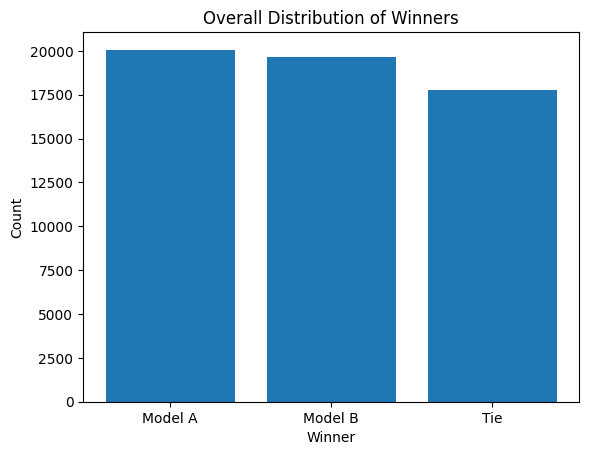

In [9]:
winner_counts = [
    train['winner_model_a'].sum(),
    train['winner_model_b'].sum(),
    train['winner_tie'].sum()
]
labels = ['Model A', 'Model B', 'Tie']

plt.bar(labels, winner_counts)
plt.title('Overall Distribution of Winners')
plt.xlabel('Winner')
plt.ylabel('Count')
plt.show()


## distribution of distinct models

In [10]:
model_a_counts = train['model_a'].value_counts()
model_b_counts = train['model_b'].value_counts()

print("Unique models in model_a column:", model_a_counts.index.nunique())
print("Unique models in model_b column:", model_b_counts.index.nunique())

print("\nTop 5 models in model_a column:")
print(model_a_counts.head(5))

print("\nTop 5 models in model_b column:")
print(model_b_counts.head(5))


Unique models in model_a column: 64
Unique models in model_b column: 64

Top 5 models in model_a column:
model_a
gpt-4-1106-preview    3678
gpt-3.5-turbo-0613    3553
gpt-4-0613            3099
claude-2.1            2859
gpt-4-0314            2087
Name: count, dtype: int64

Top 5 models in model_b column:
model_b
gpt-4-1106-preview    3709
gpt-3.5-turbo-0613    3530
gpt-4-0613            3066
claude-2.1            2724
claude-instant-1      2051
Name: count, dtype: int64


## Pairing models against each other

In [11]:
pair_counts = train.groupby(['model_a', 'model_b']).size().reset_index(name='count')
pair_counts.sort_values('count', ascending=False).head(10)

,model_a,model_b,count
278,claude-2.1,gpt-4-1106-preview,557
951,gpt-4-1106-preview,claude-2.1,516
964,gpt-4-1106-preview,gpt-4-0613,502
911,gpt-4-0613,gpt-4-1106-preview,480
263,claude-2.1,claude-1,412
277,claude-2.1,gpt-4-0613,392
706,gpt-3.5-turbo-0613,gpt-4-1106-preview,370
896,gpt-4-0613,claude-2.1,366
153,claude-1,claude-2.1,351
960,gpt-4-1106-preview,gpt-3.5-turbo-0613,337


## Relationship between models and winners

In [17]:
# Count how many times each model is in the A slot and how many times it wins
model_a_appearances = train.groupby('model_a')['model_a'].count()
model_a_wins = train.loc[train['winner_model_a'] == 1].groupby('model_a')['model_a'].count()

# Similarly for B
model_b_appearances = train.groupby('model_b')['model_b'].count()
model_b_wins = train.loc[train['winner_model_b'] == 1].groupby('model_b')['model_b'].count()

# Convert Series to DataFrames so we can combine
model_a_appearances = model_a_appearances.to_frame('a_appearances')
model_a_wins = model_a_wins.to_frame('a_wins')
model_b_appearances = model_b_appearances.to_frame('b_appearances')
model_b_wins = model_b_wins.to_frame('b_wins')

# Merge them
model_stats = model_a_appearances.merge(model_a_wins, left_index=True, right_index=True, how='left')
model_stats = model_stats.merge(model_b_appearances, left_index=True, right_index=True, how='left')
model_stats = model_stats.merge(model_b_wins, left_index=True, right_index=True, how='left')

model_stats.fillna(0, inplace=True)  # fill missing values with 0

# Calculate total appearances and total wins
model_stats['total_appearances'] = model_stats['a_appearances'] + model_stats['b_appearances']
model_stats['total_wins'] = model_stats['a_wins'] + model_stats['b_wins']
model_stats['win_rate'] = model_stats['total_wins'] / model_stats['total_appearances']

model_stats.sort_values('win_rate', ascending=False).head(10)


,a_appearances,a_wins,b_appearances,b_wins,total_appearances,total_wins,win_rate
model_a,,,,,,,
gpt-4-1106-preview,3678,2019,3709,2054,7387,4073,0.551374
gpt-3.5-turbo-0314,646,367,656,344,1302,711,0.546083
gpt-4-0125-preview,567,298,593,298,1160,596,0.513793
gpt-4-0314,2087,1033,2035,960,4122,1993,0.483503
claude-1,1955,867,2023,880,3978,1747,0.439165
gpt-4-0613,3099,1280,3066,1170,6165,2450,0.397405
claude-instant-1,2085,828,2051,814,4136,1642,0.397002
qwen1.5-72b-chat,278,117,273,98,551,215,0.390200
claude-2.0,1272,508,1184,448,2456,956,0.389251


## Handling Ties

In [13]:
tie_cases = train.loc[train['winner_tie'] == 1]
tie_count_by_model_a = tie_cases['model_a'].value_counts().head(10)
tie_count_by_model_b = tie_cases['model_b'].value_counts().head(10)

print("Models in tie (as model_a):\n", tie_count_by_model_a)
print("\nModels in tie (as model_b):\n", tie_count_by_model_b)


Models in tie (as model_a):
 model_a
gpt-3.5-turbo-0613            1105
gpt-4-1106-preview            1009
gpt-4-0613                     932
claude-2.1                     801
claude-instant-1               630
gpt-4-0314                     609
vicuna-33b                     595
claude-1                       592
mixtral-8x7b-instruct-v0.1     569
llama-2-70b-chat               568
Name: count, dtype: int64

Models in tie (as model_b):
 model_b
gpt-3.5-turbo-0613            1112
gpt-4-1106-preview            1018
gpt-4-0613                     927
claude-2.1                     813
vicuna-33b                     679
claude-1                       594
gpt-4-0314                     590
claude-instant-1               584
mixtral-8x7b-instruct-v0.1     570
llama-2-70b-chat               545
Name: count, dtype: int64


## Basic text analysis (prompts and responses)

In [ ]:
train['prompt_length'] = train['prompt'].apply(lambda x: len(str(x)))
train['response_a_length'] = train['response_a'].apply(lambda x: len(str(x)))
train['response_b_length'] = train['response_b'].apply(lambda x: len(str(x)))

train[['prompt_length', 'response_a_length', 'response_b_length']].describe()

,prompt_length,response_a_length,response_b_length
count,57477.000000,57477.000000,57477.000000
mean,369.198584,1377.818919,1386.162169
std,1073.341472,1513.932333,1537.800488
min,7.000000,4.000000,4.000000
25%,52.000000,408.000000,413.000000
50%,96.000000,1076.000000,1086.000000
75%,243.000000,1862.000000,1873.000000
max,33056.000000,54058.000000,53830.000000


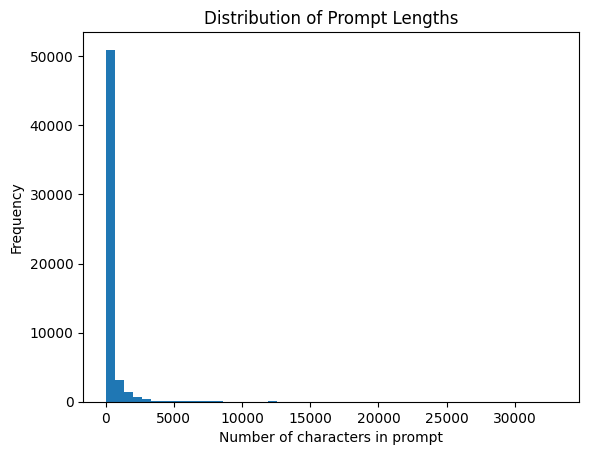

In [19]:
plt.hist(train['prompt_length'], bins=50)
plt.title("Distribution of Prompt Lengths")
plt.xlabel("Number of characters in prompt")
plt.ylabel("Frequency")
plt.show()


In [ ]:
# For model A
train['A_wins'] = (train['winner_model_a'] == 1).astype(int)
train['B_wins'] = (train['winner_model_b'] == 1).astype(int)

response_a_winner_lengths = train.loc[train['A_wins'] == 1, 'response_a_length']
response_a_loser_lengths = train.loc[train['A_wins'] == 0, 'response_a_length']

print("Mean length of A's response when A wins:", response_a_winner_lengths.mean())
print("Mean length of A's response when A loses:", response_a_loser_lengths.mean())

# for model B
response_b_winner_lengths = train.loc[train['B_wins'] == 1, 'response_b_length']
response_b_loser_lengths = train.loc[train['B_wins'] == 0, 'response_b_length']

print("Mean length of B's response when B wins:", response_b_winner_lengths.mean())
print("Mean length of B's response when B loses:", response_b_loser_lengths.mean())


Mean length of A's response when A wins: 1567.6192185007974
Mean length of A's response when A loses: 1276.0320209552829
Mean length of B's response when B wins: 1569.1136779971505
Mean length of B's response when B loses: 1291.1096100462657


## longer responses tend to win!

## Checking if positional bias exist

A Wins: 20064
B Wins: 19652


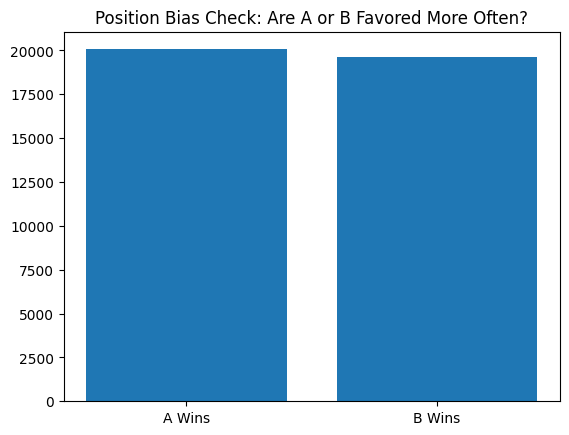

In [21]:
a_wins_count = train['winner_model_a'].sum()
b_wins_count = train['winner_model_b'].sum()

print("A Wins:", a_wins_count)
print("B Wins:", b_wins_count)

plt.bar(['A Wins', 'B Wins'], [a_wins_count, b_wins_count])
plt.title('Position Bias Check: Are A or B Favored More Often?')
plt.show()


# Check if any models are tie prone?

In [26]:
# 1. Count how many times each model is involved in a tie as model_a
tie_for_model_a = train.loc[train['winner_tie'] == 1].groupby('model_a')['winner_tie'].count()

# 2. Count how many times each model is involved in a tie as model_b
tie_for_model_b = train.loc[train['winner_tie'] == 1].groupby('model_b')['winner_tie'].count()

# 3. Convert them to DataFrames for easier merging
tie_for_model_a = tie_for_model_a.to_frame('ties_as_a')
tie_for_model_b = tie_for_model_b.to_frame('ties_as_b')

# 4. Merge them on model name (the index)
tie_stats = tie_for_model_a.merge(tie_for_model_b, left_index=True, right_index=True, how='outer')
tie_stats.fillna(0, inplace=True)

# 5. Calculate total ties per model
tie_stats['total_ties'] = tie_stats['ties_as_a'] + tie_stats['ties_as_b']

# 6. You also need the total_appearances per model (which you likely have from your earlier `model_stats` DataFrame).
#    We'll assume you already have something like:
#      model_stats['total_appearances'] = model_stats['a_appearances'] + model_stats['b_appearances']

#    So let’s merge `tie_stats` with `model_stats` so you can divide total ties by appearances:
tie_stats = tie_stats.merge(model_stats[['total_appearances']], left_index=True, right_index=True, how='left')

# 7. Calculate tie_rate for each model
tie_stats['tie_rate'] = tie_stats['total_ties'] / tie_stats['total_appearances']

# 8. Finally, sort by tie_rate to see who’s most "tie-prone"
tie_stats_sorted = tie_stats.sort_values('tie_rate', ascending=False)
tie_stats_sorted.head(10)

,ties_as_a,ties_as_b,total_ties,total_appearances,tie_rate
model_a,,,,,
qwen1.5-4b-chat,35,41,76,200,0.380000
openhermes-2.5-mistral-7b,172,171,343,952,0.360294
dolphin-2.2.1-mistral-7b,74,59,133,373,0.356568
zephyr-7b-alpha,83,62,145,412,0.351942
openchat-3.5-0106,34,51,85,244,0.348361
deepseek-llm-67b-chat,147,129,276,795,0.347170
openchat-3.5,280,286,566,1632,0.346814
llama-2-7b-chat,303,316,619,1793,0.345231
chatglm-6b,202,233,435,1261,0.344964


### some models are prone to tie

---

# Preprocessing

In [ ]:
# Finalized Preprocessing Workflow for features-v3.parquet

import pandas as pd
import numpy as np
import torch
from sentence_transformers import SentenceTransformer
from textstat import textstat

# Initialize model
embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Load and preprocess dataset
def load_and_preprocess(path):
    df = pd.read_csv(path)
    df["prompt"] = df["prompt"].apply(lambda x: eval(x)[0])
    df["response_a"] = df["response_a"].apply(lambda x: eval(x.replace("null", "''"))[0])
    df["response_b"] = df["response_b"].apply(lambda x: eval(x.replace("null", "''"))[0])
    return df

train_df = load_and_preprocess("train.csv")
sentiment_df = load_and_preprocess("train1.csv")

# Encode class labels
class_mapping = {"winner_model_a": 0, "winner_model_b": 1, "winner_tie": 2}
train_df["class_label"] = train_df[["winner_model_a", "winner_model_b", "winner_tie"]].idxmax(axis=1).map(class_mapping)
sentiment_df["class_label"] = sentiment_df[["winner_model_a", "winner_model_b", "winner_tie"]].idxmax(axis=1).map(class_mapping)

# Remove encoding errors
def safe_encode(row):
    try:
        row["prompt"] = row["prompt"].encode("utf-8").decode("utf-8")
        row["response_a"] = row["response_a"].encode("utf-8").decode("utf-8")
        row["response_b"] = row["response_b"].encode("utf-8").decode("utf-8")
        row["encode_fail"] = False
    except:
        row["encode_fail"] = True
    return row

train_df = train_df.apply(safe_encode, axis=1)
sentiment_df = sentiment_df.apply(safe_encode, axis=1)

train_df = train_df[~train_df["encode_fail"]].reset_index(drop=True)
sentiment_df = sentiment_df[~sentiment_df["encode_fail"]].reset_index(drop=True)

# Basic text statistics
sentiment_df["prompt_wordcount"] = sentiment_df["prompt"].apply(lambda x: len(x.split(" ")))
sentiment_df["resa_wordcount"] = sentiment_df["response_a"].apply(lambda x: len(x.split(" ")))
sentiment_df["resb_wordcount"] = sentiment_df["response_b"].apply(lambda x: len(x.split(" ")))


In [ ]:
# Sentiment scores using VADER
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sentiment_analyzer = SentimentIntensityAnalyzer()
sentiment_df["sent_a"] = sentiment_df["response_a"].apply(lambda x: sentiment_analyzer.polarity_scores(x)['compound'])
sentiment_df["sent_b"] = sentiment_df["response_b"].apply(lambda x: sentiment_analyzer.polarity_scores(x)['compound'])

# Readability scores
sentiment_df["readability_a"] = sentiment_df["response_a"].apply(textstat.flesch_reading_ease)
sentiment_df["readability_b"] = sentiment_df["response_b"].apply(textstat.flesch_reading_ease)
sentiment_df["readability_diff"] = sentiment_df["readability_a"] - sentiment_df["readability_b"]

# Number of sentences
sentiment_df["n_sentence_a"] = sentiment_df["response_a"].str.count(".")
sentiment_df["n_sentence_b"] = sentiment_df["response_b"].str.count(".")
sentiment_df["n_sentence_diff"] = sentiment_df["n_sentence_a"] - sentiment_df["n_sentence_b"]

# Non-alphabetic character counts
def non_alpha_count(text):
    return sum(1 for c in text if not c.isalpha())

sentiment_df["non_alpha_a"] = sentiment_df["response_a"].apply(non_alpha_count)
sentiment_df["non_alpha_b"] = sentiment_df["response_b"].apply(non_alpha_count)
sentiment_df["non_alpha_diff"] = sentiment_df["non_alpha_a"] - sentiment_df["non_alpha_b"]


In [ ]:
# Generate embeddings
prompt_embs = embedding_model.encode(train_df["prompt"].tolist(), batch_size=64)
resp_a_embs = embedding_model.encode(train_df["response_a"].tolist(), batch_size=64)
resp_b_embs = embedding_model.encode(train_df["response_b"].tolist(), batch_size=64)

# Compute similarities
prompt_embs_gpu = torch.nn.functional.normalize(torch.tensor(prompt_embs).cuda())
resp_a_embs_gpu = torch.nn.functional.normalize(torch.tensor(resp_a_embs).cuda())
resp_b_embs_gpu = torch.nn.functional.normalize(torch.tensor(resp_b_embs).cuda())

sim_prompt_a = (prompt_embs_gpu * resp_a_embs_gpu).sum(dim=1).cpu().numpy()
sim_prompt_b = (prompt_embs_gpu * resp_b_embs_gpu).sum(dim=1).cpu().numpy()
sim_diff = sim_prompt_a - sim_prompt_b
sim_res_a_res_b = (resp_a_embs_gpu * resp_b_embs_gpu).sum(dim=1).cpu().numpy()

# One-hot encode labels
one_hot_labels = pd.get_dummies(train_df["class_label"], prefix="class_label")

# Assemble final DataFrame
final_df = pd.DataFrame({
    "prompt_wordcount": sentiment_df["prompt_wordcount"],
    "resa_wordcount": sentiment_df["resa_wordcount"],
    "resb_wordcount": sentiment_df["resb_wordcount"],
    "sent_a": sentiment_df["sent_a"],
    "sent_b": sentiment_df["sent_b"],
    "readability_a": sentiment_df["readability_a"],
    "readability_b": sentiment_df["readability_b"],
    "readability_diff": sentiment_df["readability_diff"],
    "n_sentence_a": sentiment_df["n_sentence_a"],
    "n_sentence_b": sentiment_df["n_sentence_b"],
    "n_sentence_diff": sentiment_df["n_sentence_diff"],
    "non_alpha_a": sentiment_df["non_alpha_a"],
    "non_alpha_b": sentiment_df["non_alpha_b"],
    "non_alpha_diff": sentiment_df["non_alpha_diff"],
    "sim_prompt_a_res": sim_prompt_a,
    "sim_prompt_b_res": sim_prompt_b,
    "sim_diff": sim_diff,
    "sim_res_a_res_b": sim_res_a_res_b
})

final_df = pd.concat([final_df, one_hot_labels.reset_index(drop=True)], axis=1)

# Save final features to parquet
final_df.to_parquet("features-v3.parquet", index=False)


---

# Model training

In [4]:
# load embedding
feature_v2 = pd.read_parquet('features-v3.parquet')
cos_similarity = pd.read_csv("similarity.csv")

merged_df = pd.merge(cos_similarity, feature_v2, left_index=True, right_index=True, how='left')
merged_df.head()

,sim_prompt_a_res_x,sim_prompt_b_res_x,sim_diff_x,sim_res_a_res_b_x,prompt_wordcount,resa_wordcount,resb_wordcount,sent_a,sent_b,readability_a,...,non_alpha_a,non_alpha_b,non_alpha_diff,sim_prompt_a_res_y,sim_prompt_b_res_y,sim_diff_y,sim_res_a_res_b_y,class_label_0,class_label_1,class_label_2
0,0.707489,0.626828,0.080661,0.695821,28,656,204,0.9936,0.9200,14.19,...,540,134,406,0.707489,0.626828,0.080661,0.695821,1,0,0
1,0.800323,0.836697,-0.036374,0.893782,35,537,591,0.9485,0.9529,40.72,...,133,237,-104,0.800323,0.836697,-0.036374,0.893782,0,1,0
2,0.686887,0.728341,-0.041453,0.821830,9,141,282,0.2695,-0.2500,62.27,...,213,456,-243,0.686887,0.728341,-0.041453,0.821830,0,0,1
3,0.784458,0.742154,0.042305,0.806848,18,536,265,0.9868,0.9792,35.20,...,637,311,326,0.784458,0.742154,0.042305,0.806848,1,0,0
4,0.828166,0.883962,-0.055797,0.920341,14,236,122,0.9702,0.8519,56.49,...,287,148,139,0.828166,0.883962,-0.055797,0.920341,0,1,0


In [5]:
X_features_v2 = merged_df.iloc[:, :-3] 
y_v2 = merged_df.iloc[:, -3:]          # Last 3 columns as label
y_v2 = y_v2.values.argmax(axis=1)      # Convert back to label (0,1,2)

In [8]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_features_v2, y_v2, test_size=0.2, random_state=32)

# Softmax Regression
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000)
model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

/opt/homebrew/Caskroom/miniconda/base/envs/deberta_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.45      0.56      0.50      3956
           1       0.45      0.53      0.49      3844
           2       0.43      0.23      0.30      3577

    accuracy                           0.45     11377
   macro avg       0.44      0.44      0.43     11377
weighted avg       0.45      0.45      0.43     11377



# Visualize Feature Importance
Use SHAP to visualize which feature contributes the most

/opt/homebrew/Caskroom/miniconda/base/envs/deberta_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


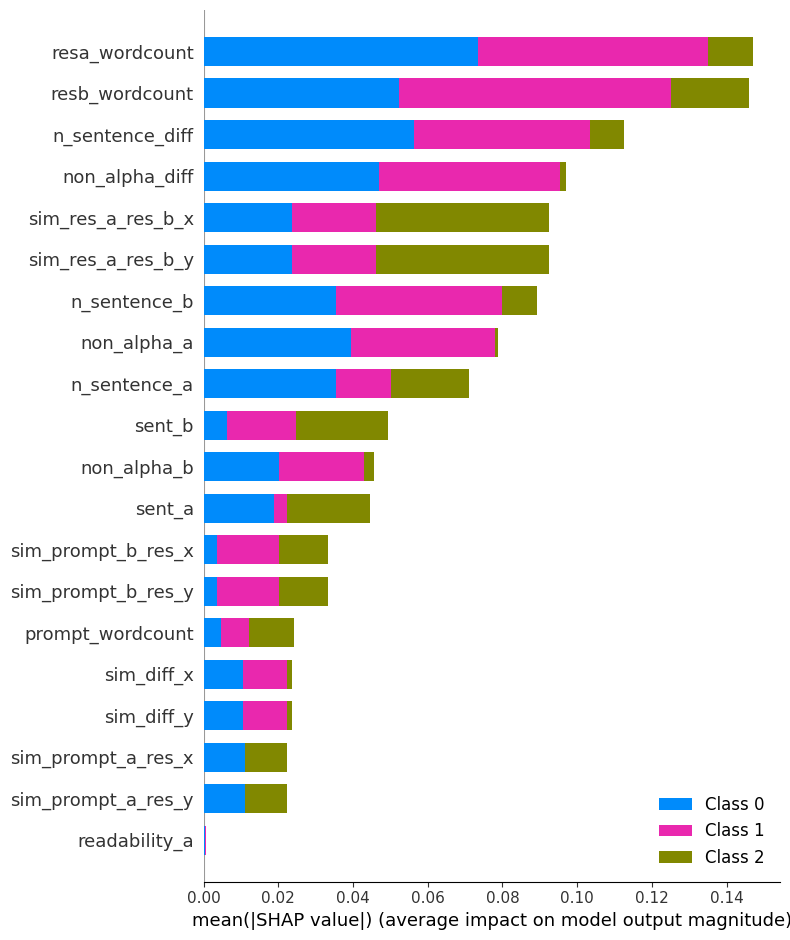

ValueError: visualize() can only display Explanation objects (or arrays of them)!

In [9]:
import shap

explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_test.iloc[0])

